In [1]:
# Import the necessary packages and libraries #
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy
import numpy.matlib
import pandas 
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
import tensorflow
from tensorflow import keras 
import os
from IPython.display import clear_output
from numba import jit
from sklearn.neighbors import DistanceMetric

In [2]:
pandas.set_option("precision", 10)

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [6]:
# Import the MatLab data #

matlabData = sio.loadmat(file_name='./data/s2_sl2p_uniform_10_replicates_sobol_prosail_inout.mat', variable_names=['Input', 'Output'])

In [7]:
# Extract the input and output data #

bands = pandas.DataFrame(data=matlabData['Input']['Rho_Toc'][0][0])
angles = pandas.DataFrame(data=matlabData['Input']['Angles'][0][0])
LAI = pandas.Series(data=matlabData['Output']['LAI'][0][0].flatten())
FAPAR = pandas.Series(data=matlabData['Output']['FAPAR'][0][0].flatten())
FCOVER = pandas.Series(data=matlabData['Output']['FCOVER'][0][0].flatten())

In [8]:
# Standardize the calibration data #

input_df = pandas.concat([bands, angles], axis=1, join='outer')

input_df.columns = ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'A1', 'A2', 'A3']

input_df_centred = input_df - input_df.mean()

input_df_normed = input_df_centred * input_df_centred.pow(2).sum().pow(-0.5)

LAI_mean = LAI.mean()
FAPAR_mean = FAPAR.mean()
FCOVER_mean = FCOVER.mean()

LAI_centred = LAI.subtract(LAI_mean)
FAPAR_centred = FAPAR.subtract(FAPAR_mean)
FCOVER_centred = FCOVER.subtract(FCOVER_mean)

cal_data_scaled = pandas.concat([input_df_normed, LAI_centred, FAPAR_centred, FCOVER_centred], axis=1, join='outer')

cal_data_scaled.columns = ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'A1', 'A2', 'A3', 'LAI', 'FAPAR', 'FCOVER']

cal_data_scaled

,B0,B1,B2,B3,B4,B5,B6,B7,A1,A2,A3,LAI,FAPAR,FCOVER
0,0.0033094104,0.0033933009,0.0031395085,-0.0021609234,-0.0034622801,-0.0035805871,-0.0014617342,0.0001377014,-0.0043794833,-0.0035917914,-0.0022237473,-4.5,-0.3664171405,-0.3376439765
1,0.0010750957,0.0048052685,0.0023618409,-0.0003639014,-0.0012843598,-0.0009449439,0.0027310201,0.0044705136,0.0037527329,-0.0035743687,-0.0018591298,-4.5,-0.2758468258,-0.2841473161
2,-0.0022929068,0.0011309476,-0.0028727197,-0.0066173779,-0.0070545659,-0.0072076046,-0.0044201548,-0.0011331458,-0.0005375280,-0.0006417382,0.0025092119,-4.5,-0.5649323664,-0.5855197757
3,-0.0020559704,-0.0002309697,-0.0017273277,-0.0051560894,-0.0057292826,-0.0056628783,-0.0031721314,-0.0008763904,0.0007902885,0.0012897426,0.0031377984,-4.5,-0.4540206403,-0.4447193319
4,-0.0006766658,0.0103727460,0.0028263351,-0.0031423640,-0.0039174776,-0.0039340306,0.0031744431,0.0049217551,0.0038286154,0.0019817240,-0.0034695628,-4.5,-0.5164482028,-0.5613786646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122875,-0.0017966211,-0.0018976856,-0.0020361413,-0.0017789206,-0.0015314958,-0.0014754344,-0.0039703241,-0.0032858939,-0.0043023526,0.0024787674,-0.0035369952,4.5,0.1399313717,0.1350865211
122876,0.0002656087,0.0006883065,0.0001012185,-0.0018411151,-0.0019154414,-0.0017897347,-0.0019923222,-0.0003886648,-0.0048677474,0.0028727135,0.0033901822,4.5,0.0029873394,-0.0145159439
122877,-0.0019563157,-0.0007206394,-0.0017075880,-0.0029944036,-0.0027833101,-0.0029968457,-0.0035358971,-0.0022574491,-0.0016551080,0.0027354754,-0.0037417763,4.5,0.0129694704,-0.0057634043
122878,-0.0027684148,-0.0017592728,-0.0030936142,0.0008160573,0.0023194837,0.0019416935,-0.0016862533,-0.0029920554,-0.0050871448,0.0020402634,-0.0033231332,4.5,0.1755475803,0.1812556883


In [9]:
# Create subset id's #

rep = 10

subsets = numpy.arange(0, int(cal_data_scaled.shape[0]/10))

subset_ids = numpy.matlib.repmat(subsets, 1, rep)

cal_data_scaled['subset_id'] = subset_ids[0]

cal_data_scaled.columns = ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'A1', 'A2', 'A3', 'LAI', 'FAPAR', 'FCOVER', 'subset_id']

cal_data_scaled

,B0,B1,B2,B3,B4,B5,B6,B7,A1,A2,A3,LAI,FAPAR,FCOVER,subset_id
0,0.0033094104,0.0033933009,0.0031395085,-0.0021609234,-0.0034622801,-0.0035805871,-0.0014617342,0.0001377014,-0.0043794833,-0.0035917914,-0.0022237473,-4.5,-0.3664171405,-0.3376439765,0
1,0.0010750957,0.0048052685,0.0023618409,-0.0003639014,-0.0012843598,-0.0009449439,0.0027310201,0.0044705136,0.0037527329,-0.0035743687,-0.0018591298,-4.5,-0.2758468258,-0.2841473161,1
2,-0.0022929068,0.0011309476,-0.0028727197,-0.0066173779,-0.0070545659,-0.0072076046,-0.0044201548,-0.0011331458,-0.0005375280,-0.0006417382,0.0025092119,-4.5,-0.5649323664,-0.5855197757,2
3,-0.0020559704,-0.0002309697,-0.0017273277,-0.0051560894,-0.0057292826,-0.0056628783,-0.0031721314,-0.0008763904,0.0007902885,0.0012897426,0.0031377984,-4.5,-0.4540206403,-0.4447193319,3
4,-0.0006766658,0.0103727460,0.0028263351,-0.0031423640,-0.0039174776,-0.0039340306,0.0031744431,0.0049217551,0.0038286154,0.0019817240,-0.0034695628,-4.5,-0.5164482028,-0.5613786646,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122875,-0.0017966211,-0.0018976856,-0.0020361413,-0.0017789206,-0.0015314958,-0.0014754344,-0.0039703241,-0.0032858939,-0.0043023526,0.0024787674,-0.0035369952,4.5,0.1399313717,0.1350865211,12283
122876,0.0002656087,0.0006883065,0.0001012185,-0.0018411151,-0.0019154414,-0.0017897347,-0.0019923222,-0.0003886648,-0.0048677474,0.0028727135,0.0033901822,4.5,0.0029873394,-0.0145159439,12284
122877,-0.0019563157,-0.0007206394,-0.0017075880,-0.0029944036,-0.0027833101,-0.0029968457,-0.0035358971,-0.0022574491,-0.0016551080,0.0027354754,-0.0037417763,4.5,0.0129694704,-0.0057634043,12285
122878,-0.0027684148,-0.0017592728,-0.0030936142,0.0008160573,0.0023194837,0.0019416935,-0.0016862533,-0.0029920554,-0.0050871448,0.0020402634,-0.0033231332,4.5,0.1755475803,0.1812556883,12286


In [10]:
# Sample data to create reference database # 

ref_data = cal_data_scaled.sample(n=100, ignore_index=False)

ref_data

,B0,B1,B2,B3,B4,B5,B6,B7,A1,A2,A3,LAI,FAPAR,FCOVER,subset_id
34366,0.0013435372,0.0053698925,0.0009076280,-0.0013449279,-0.0018657577,-0.0020445645,-0.0009551405,0.0015445762,-0.0048664303,0.0032664234,0.0034603399,-2.5,-0.1082730635,-0.1585625760,9790
50957,-0.0030036510,-0.0014566885,-0.0032459064,-0.0001708924,0.0012347148,0.0009324905,-0.0003461772,-0.0014834728,-0.0015176221,0.0033807931,0.0035778281,-0.5,0.1252138101,0.1255803206,1805
107707,-0.0039423119,-0.0027146693,-0.0042678760,-0.0043655782,-0.0034073798,-0.0033531020,-0.0048885725,-0.0029831442,0.0010694757,-0.0011472938,-0.0024455055,3.5,0.0007371214,-0.0163659070,9403
13153,0.0020060786,0.0036482181,0.0022964211,0.0029313714,0.0025863087,0.0025717952,0.0083296464,0.0074828963,-0.0008322880,0.0013600306,-0.0024395524,-3.5,-0.0312308500,-0.0468426382,865
118372,-0.0027464701,-0.0015946069,-0.0030319666,0.0017243373,0.0045142769,0.0045606494,0.0015388500,-0.0007295197,-0.0006883405,-0.0068333315,-0.0019609898,4.5,0.1729935801,0.1795535518,7780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64230,0.0009198655,-0.0015476296,0.0006711346,0.0032716254,0.0036906702,0.0033210145,0.0024999407,0.0007869438,0.0010522191,0.0020934621,0.0029323799,0.5,0.1430302441,0.1534455364,2790
48001,0.0006505460,-0.0014687160,0.0005231812,0.0020071203,0.0018158382,0.0017258039,0.0040814534,0.0030272957,-0.0001747251,0.0011607829,0.0025326186,-1.5,0.0590296904,0.0711511336,11137
104944,0.0004382035,-0.0015566670,0.0003461161,0.0034158922,0.0040433642,0.0039850943,0.0029861697,0.0007195073,0.0036366422,-0.0004565982,-0.0023782935,3.5,0.1643998835,0.1760878938,6640
10554,-0.0006561287,0.0028877709,-0.0000359382,-0.0010539843,-0.0014880916,-0.0015640218,0.0048571473,0.0066890092,0.0015370011,0.0014481819,-0.0028531391,-4.5,-0.2668045711,-0.2769348759,10554


In [11]:
# List of indices to remove from the calibration database #

index_list = ref_data.index.values

In [12]:
ref_data = ref_data.reset_index(drop=True)

In [13]:
# Removes the indices from calibration database that are in the reference database #

cal_data_scaled = cal_data_scaled.drop(index_list)

In [14]:
cal_data_scaled = cal_data_scaled.reset_index(drop=True)

In [15]:
ref_array = numpy.array(ref_data[['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7','LAI']])
print(len(ref_array))
cal_array = numpy.array(cal_data_scaled[['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7','LAI']])
print(len(cal_array))
cal_indices = numpy.array(cal_data_scaled.index.values)
print(len(cal_indices))
ref_indices = numpy.array(ref_data.index.values)
print(len(ref_indices))

100
122780
122780
100


In [16]:
dist = DistanceMetric.get_metric('euclidean')

In [17]:
probs = numpy.exp(-numpy.amin(dist.pairwise(cal_array,ref_array),1))

In [18]:
print(len(probs))

122780


In [19]:
# Normalize the Probabilities #
norm_prob = numpy.array(probs)/sum(probs)

In [20]:
# Initialize the probability column in the calibration database #

cal_data_scaled['prob'] = norm_prob

cal_data_scaled.columns = ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'A1', 'A2', 'A3', 'LAI', 'FAPAR', 'FCOVER', 'subset_id', 'prob']

cal_data_scaled

,B0,B1,B2,B3,B4,B5,B6,B7,A1,A2,A3,LAI,FAPAR,FCOVER,subset_id,prob
0,0.0033094104,0.0033933009,0.0031395085,-0.0021609234,-0.0034622801,-0.0035805871,-0.0014617342,0.0001377014,-0.0043794833,-0.0035917914,-0.0022237473,-4.5,-0.3664171405,-0.3376439765,0,0.0000081291
1,0.0010750957,0.0048052685,0.0023618409,-0.0003639014,-0.0012843598,-0.0009449439,0.0027310201,0.0044705136,0.0037527329,-0.0035743687,-0.0018591298,-4.5,-0.2758468258,-0.2841473161,1,0.0000081583
2,-0.0022929068,0.0011309476,-0.0028727197,-0.0066173779,-0.0070545659,-0.0072076046,-0.0044201548,-0.0011331458,-0.0005375280,-0.0006417382,0.0025092119,-4.5,-0.5649323664,-0.5855197757,2,0.0000081558
3,-0.0020559704,-0.0002309697,-0.0017273277,-0.0051560894,-0.0057292826,-0.0056628783,-0.0031721314,-0.0008763904,0.0007902885,0.0012897426,0.0031377984,-4.5,-0.4540206403,-0.4447193319,3,0.0000081616
4,-0.0006766658,0.0103727460,0.0028263351,-0.0031423640,-0.0039174776,-0.0039340306,0.0031744431,0.0049217551,0.0038286154,0.0019817240,-0.0034695628,-4.5,-0.5164482028,-0.5613786646,4,0.0000081425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122775,-0.0017966211,-0.0018976856,-0.0020361413,-0.0017789206,-0.0015314958,-0.0014754344,-0.0039703241,-0.0032858939,-0.0043023526,0.0024787674,-0.0035369952,4.5,0.1399313717,0.1350865211,12283,0.0000081646
122776,0.0002656087,0.0006883065,0.0001012185,-0.0018411151,-0.0019154414,-0.0017897347,-0.0019923222,-0.0003886648,-0.0048677474,0.0028727135,0.0033901822,4.5,0.0029873394,-0.0145159439,12284,0.0000081267
122777,-0.0019563157,-0.0007206394,-0.0017075880,-0.0029944036,-0.0027833101,-0.0029968457,-0.0035358971,-0.0022574491,-0.0016551080,0.0027354754,-0.0037417763,4.5,0.0129694704,-0.0057634043,12285,0.0000081460
122778,-0.0027684148,-0.0017592728,-0.0030936142,0.0008160573,0.0023194837,0.0019416935,-0.0016862533,-0.0029920554,-0.0050871448,0.0020402634,-0.0033231332,4.5,0.1755475803,0.1812556883,12286,0.0000081575


In [21]:
cal_data_scaled[cal_data_scaled['subset_id'] == 1]

,B0,B1,B2,B3,B4,B5,B6,B7,A1,A2,A3,LAI,FAPAR,FCOVER,subset_id,prob
1,0.0010750957,0.0048052685,0.0023618409,-0.0003639014,-0.0012843598,-0.0009449439,0.0027310201,0.0044705136,0.0037527329,-0.0035743687,-0.0018591298,-4.5,-0.2758468258,-0.2841473161,1,0.0000081583
12279,0.0008806302,0.0013709811,0.0014113915,0.0015028196,0.0006862160,0.0007451041,-0.0001689173,0.0001419297,0.0037527329,-0.0035743687,-0.0018591298,-3.5,-0.0393250851,-0.0353561167,1,0.0000081206
24559,0.0007845647,-0.0001938305,0.0009497885,0.0023884634,0.0017544023,0.0016367721,-0.0015601067,-0.0018376717,0.0037527329,-0.0035743687,-0.0018591298,-2.5,0.0703062173,0.0805948235,1,0.0000081428
36840,0.0007499045,-0.0009037402,0.0007512430,0.0028102010,0.0023417105,0.0021283742,-0.0021679326,-0.0027271788,0.0037527329,-0.0035743687,-0.0018591298,-1.5,0.1218262055,0.1346345989,1,0.0000081405
49120,0.0007415156,-0.0012246935,0.0006704069,0.0030112971,0.0026650922,0.0024025464,-0.0024275509,-0.0031267788,0.0037527329,-0.0035743687,-0.0018591298,-0.5,0.1461292832,0.1598202275,1,0.0000081327
61397,0.0007429707,-0.0013689006,0.0006397196,0.0031083098,0.0028433019,0.0025560103,-0.0025377310,-0.0033065989,0.0037527329,-0.0035743687,-0.0018591298,0.5,0.1575945403,0.1715581721,1,0.0000081478
73667,0.0007475886,-0.0014329080,0.0006299847,0.0031565188,0.0029419830,0.0026423715,-0.0025838446,-0.0033874110,0.0037527329,-0.0035743687,-0.0018591298,1.5,0.1629973868,0.1770287262,1,0.0000081486
85948,0.0007528067,-0.0014606400,0.0006287692,0.0031817818,0.0029972257,0.0026915069,-0.0026023403,-0.0034234749,0.0037527329,-0.0035743687,-0.0018591298,2.5,0.1655398867,0.1795783176,1,0.0000081450
98225,0.0007577145,-0.0014720663,0.0006307967,0.0031960890,0.0030287350,0.0027199905,-0.0026089345,-0.0034393021,0.0037527329,-0.0035743687,-0.0018591298,3.5,0.1667347594,0.1807665731,1,0.0000081425
110504,0.0007620489,-0.0014762484,0.0006338527,0.0032049956,0.0030472198,0.0027369717,-0.0026104745,-0.0034460029,0.0037527329,-0.0035743687,-0.0018591298,4.5,0.1672956379,0.1813203682,1,0.0000081453


In [22]:
# Assign max probability in each subset #

cal_data_scaled['prob'] = cal_data_scaled.groupby('subset_id')['prob'].transform('max')

cal_data_scaled

,B0,B1,B2,B3,B4,B5,B6,B7,A1,A2,A3,LAI,FAPAR,FCOVER,subset_id,prob
0,0.0033094104,0.0033933009,0.0031395085,-0.0021609234,-0.0034622801,-0.0035805871,-0.0014617342,0.0001377014,-0.0043794833,-0.0035917914,-0.0022237473,-4.5,-0.3664171405,-0.3376439765,0,0.0000081600
1,0.0010750957,0.0048052685,0.0023618409,-0.0003639014,-0.0012843598,-0.0009449439,0.0027310201,0.0044705136,0.0037527329,-0.0035743687,-0.0018591298,-4.5,-0.2758468258,-0.2841473161,1,0.0000081583
2,-0.0022929068,0.0011309476,-0.0028727197,-0.0066173779,-0.0070545659,-0.0072076046,-0.0044201548,-0.0011331458,-0.0005375280,-0.0006417382,0.0025092119,-4.5,-0.5649323664,-0.5855197757,2,0.0000081643
3,-0.0020559704,-0.0002309697,-0.0017273277,-0.0051560894,-0.0057292826,-0.0056628783,-0.0031721314,-0.0008763904,0.0007902885,0.0012897426,0.0031377984,-4.5,-0.4540206403,-0.4447193319,3,0.0000081719
4,-0.0006766658,0.0103727460,0.0028263351,-0.0031423640,-0.0039174776,-0.0039340306,0.0031744431,0.0049217551,0.0038286154,0.0019817240,-0.0034695628,-4.5,-0.5164482028,-0.5613786646,4,0.0000081614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122775,-0.0017966211,-0.0018976856,-0.0020361413,-0.0017789206,-0.0015314958,-0.0014754344,-0.0039703241,-0.0032858939,-0.0043023526,0.0024787674,-0.0035369952,4.5,0.1399313717,0.1350865211,12283,0.0000081666
122776,0.0002656087,0.0006883065,0.0001012185,-0.0018411151,-0.0019154414,-0.0017897347,-0.0019923222,-0.0003886648,-0.0048677474,0.0028727135,0.0033901822,4.5,0.0029873394,-0.0145159439,12284,0.0000081555
122777,-0.0019563157,-0.0007206394,-0.0017075880,-0.0029944036,-0.0027833101,-0.0029968457,-0.0035358971,-0.0022574491,-0.0016551080,0.0027354754,-0.0037417763,4.5,0.0129694704,-0.0057634043,12285,0.0000081629
122778,-0.0027684148,-0.0017592728,-0.0030936142,0.0008160573,0.0023194837,0.0019416935,-0.0016862533,-0.0029920554,-0.0050871448,0.0020402634,-0.0033231332,4.5,0.1755475803,0.1812556883,12286,0.0000081697


In [23]:
cal_data_scaled[cal_data_scaled['subset_id'] == 1]

,B0,B1,B2,B3,B4,B5,B6,B7,A1,A2,A3,LAI,FAPAR,FCOVER,subset_id,prob
1,0.0010750957,0.0048052685,0.0023618409,-0.0003639014,-0.0012843598,-0.0009449439,0.0027310201,0.0044705136,0.0037527329,-0.0035743687,-0.0018591298,-4.5,-0.2758468258,-0.2841473161,1,0.0000081583
12279,0.0008806302,0.0013709811,0.0014113915,0.0015028196,0.0006862160,0.0007451041,-0.0001689173,0.0001419297,0.0037527329,-0.0035743687,-0.0018591298,-3.5,-0.0393250851,-0.0353561167,1,0.0000081583
24559,0.0007845647,-0.0001938305,0.0009497885,0.0023884634,0.0017544023,0.0016367721,-0.0015601067,-0.0018376717,0.0037527329,-0.0035743687,-0.0018591298,-2.5,0.0703062173,0.0805948235,1,0.0000081583
36840,0.0007499045,-0.0009037402,0.0007512430,0.0028102010,0.0023417105,0.0021283742,-0.0021679326,-0.0027271788,0.0037527329,-0.0035743687,-0.0018591298,-1.5,0.1218262055,0.1346345989,1,0.0000081583
49120,0.0007415156,-0.0012246935,0.0006704069,0.0030112971,0.0026650922,0.0024025464,-0.0024275509,-0.0031267788,0.0037527329,-0.0035743687,-0.0018591298,-0.5,0.1461292832,0.1598202275,1,0.0000081583
61397,0.0007429707,-0.0013689006,0.0006397196,0.0031083098,0.0028433019,0.0025560103,-0.0025377310,-0.0033065989,0.0037527329,-0.0035743687,-0.0018591298,0.5,0.1575945403,0.1715581721,1,0.0000081583
73667,0.0007475886,-0.0014329080,0.0006299847,0.0031565188,0.0029419830,0.0026423715,-0.0025838446,-0.0033874110,0.0037527329,-0.0035743687,-0.0018591298,1.5,0.1629973868,0.1770287262,1,0.0000081583
85948,0.0007528067,-0.0014606400,0.0006287692,0.0031817818,0.0029972257,0.0026915069,-0.0026023403,-0.0034234749,0.0037527329,-0.0035743687,-0.0018591298,2.5,0.1655398867,0.1795783176,1,0.0000081583
98225,0.0007577145,-0.0014720663,0.0006307967,0.0031960890,0.0030287350,0.0027199905,-0.0026089345,-0.0034393021,0.0037527329,-0.0035743687,-0.0018591298,3.5,0.1667347594,0.1807665731,1,0.0000081583
110504,0.0007620489,-0.0014762484,0.0006338527,0.0032049956,0.0030472198,0.0027369717,-0.0026104745,-0.0034460029,0.0037527329,-0.0035743687,-0.0018591298,4.5,0.1672956379,0.1813203682,1,0.0000081583


In [24]:
# Renormalize the data

re_norm_prob = numpy.array(cal_data_scaled['prob'])/sum(cal_data_scaled['prob'])

cal_data_scaled['prob'] = re_norm_prob

cal_data_scaled

,B0,B1,B2,B3,B4,B5,B6,B7,A1,A2,A3,LAI,FAPAR,FCOVER,subset_id,prob
0,0.0033094104,0.0033933009,0.0031395085,-0.0021609234,-0.0034622801,-0.0035805871,-0.0014617342,0.0001377014,-0.0043794833,-0.0035917914,-0.0022237473,-4.5,-0.3664171405,-0.3376439765,0,0.0000081431
1,0.0010750957,0.0048052685,0.0023618409,-0.0003639014,-0.0012843598,-0.0009449439,0.0027310201,0.0044705136,0.0037527329,-0.0035743687,-0.0018591298,-4.5,-0.2758468258,-0.2841473161,1,0.0000081414
2,-0.0022929068,0.0011309476,-0.0028727197,-0.0066173779,-0.0070545659,-0.0072076046,-0.0044201548,-0.0011331458,-0.0005375280,-0.0006417382,0.0025092119,-4.5,-0.5649323664,-0.5855197757,2,0.0000081474
3,-0.0020559704,-0.0002309697,-0.0017273277,-0.0051560894,-0.0057292826,-0.0056628783,-0.0031721314,-0.0008763904,0.0007902885,0.0012897426,0.0031377984,-4.5,-0.4540206403,-0.4447193319,3,0.0000081550
4,-0.0006766658,0.0103727460,0.0028263351,-0.0031423640,-0.0039174776,-0.0039340306,0.0031744431,0.0049217551,0.0038286154,0.0019817240,-0.0034695628,-4.5,-0.5164482028,-0.5613786646,4,0.0000081445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122775,-0.0017966211,-0.0018976856,-0.0020361413,-0.0017789206,-0.0015314958,-0.0014754344,-0.0039703241,-0.0032858939,-0.0043023526,0.0024787674,-0.0035369952,4.5,0.1399313717,0.1350865211,12283,0.0000081497
122776,0.0002656087,0.0006883065,0.0001012185,-0.0018411151,-0.0019154414,-0.0017897347,-0.0019923222,-0.0003886648,-0.0048677474,0.0028727135,0.0033901822,4.5,0.0029873394,-0.0145159439,12284,0.0000081386
122777,-0.0019563157,-0.0007206394,-0.0017075880,-0.0029944036,-0.0027833101,-0.0029968457,-0.0035358971,-0.0022574491,-0.0016551080,0.0027354754,-0.0037417763,4.5,0.0129694704,-0.0057634043,12285,0.0000081460
122778,-0.0027684148,-0.0017592728,-0.0030936142,0.0008160573,0.0023194837,0.0019416935,-0.0016862533,-0.0029920554,-0.0050871448,0.0020402634,-0.0033231332,4.5,0.1755475803,0.1812556883,12286,0.0000081527


In [25]:
cal_data_scaled = cal_data_scaled[cal_data_scaled['LAI'] > 3.0]

cal_data_scaled.reset_index()

,index,B0,B1,B2,B3,B4,B5,B6,B7,A1,A2,A3,LAI,FAPAR,FCOVER,subset_id,prob
0,98224,0.0083022120,0.0014015349,0.0075552584,0.0041035986,0.0022490150,0.0021341540,-0.0008794043,-0.0022594179,-0.0043794833,-0.0035917914,-0.0022237473,3.5,0.1325914751,0.1713947591,0,0.0000081431
1,98225,0.0007577145,-0.0014720663,0.0006307967,0.0031960890,0.0030287350,0.0027199905,-0.0026089345,-0.0034393021,0.0037527329,-0.0035743687,-0.0018591298,3.5,0.1667347594,0.1807665731,1,0.0000081414
2,98226,-0.0024058825,-0.0026564257,-0.0027491966,-0.0027497525,-0.0026655746,-0.0028091501,-0.0043360913,-0.0035664981,-0.0005375280,-0.0006417382,0.0025092119,3.5,0.0862049231,0.0830305682,2,0.0000081474
3,98227,0.0011774799,-0.0016538433,0.0012262204,0.0004379827,-0.0001524089,0.0001124038,-0.0036557940,-0.0036742237,0.0007902885,0.0012897426,0.0031377984,3.5,0.1459346762,0.1606903082,3,0.0000081550
4,98228,-0.0037567098,-0.0020138922,-0.0037231977,-0.0024233021,-0.0004147301,0.0000489269,-0.0018565423,-0.0019098431,0.0038286154,0.0019817240,-0.0034695628,3.5,0.1210150083,0.1119946801,4,0.0000081445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24551,122775,-0.0017966211,-0.0018976856,-0.0020361413,-0.0017789206,-0.0015314958,-0.0014754344,-0.0039703241,-0.0032858939,-0.0043023526,0.0024787674,-0.0035369952,4.5,0.1399313717,0.1350865211,12283,0.0000081497
24552,122776,0.0002656087,0.0006883065,0.0001012185,-0.0018411151,-0.0019154414,-0.0017897347,-0.0019923222,-0.0003886648,-0.0048677474,0.0028727135,0.0033901822,4.5,0.0029873394,-0.0145159439,12284,0.0000081386
24553,122777,-0.0019563157,-0.0007206394,-0.0017075880,-0.0029944036,-0.0027833101,-0.0029968457,-0.0035358971,-0.0022574491,-0.0016551080,0.0027354754,-0.0037417763,4.5,0.0129694704,-0.0057634043,12285,0.0000081460
24554,122778,-0.0027684148,-0.0017592728,-0.0030936142,0.0008160573,0.0023194837,0.0019416935,-0.0016862533,-0.0029920554,-0.0050871448,0.0020402634,-0.0033231332,4.5,0.1755475803,0.1812556883,12286,0.0000081527


In [26]:
training_data, valid_data = sklearn.model_selection.train_test_split(cal_data_scaled, test_size=4911, train_size=19645, random_state=None, shuffle=True, stratify=None)

In [27]:
training_data = training_data.reset_index(drop=True)

In [28]:
valid_data = valid_data.reset_index(drop=True)

In [29]:
LAI_training = training_data['LAI']
FAPAR_training = training_data['FAPAR']
FCOVER_training = training_data['FCOVER']

In [30]:
LAI_valid = valid_data['LAI']
FAPAR_valid = valid_data['FAPAR']
FCOVER_valid = valid_data['FCOVER']

In [31]:
training_weights = numpy.array(training_data['prob'])
valid_weights = numpy.array(valid_data['prob'])

In [32]:
training_data = training_data.drop(['LAI', 'FAPAR', 'FCOVER','subset_id','prob'], axis=1)
valid_data = valid_data.drop(['LAI', 'FAPAR', 'FCOVER','subset_id','prob'], axis=1)

In [33]:
LAImodel = sklearn.linear_model.Lars(n_nonzero_coefs=4)
LAImodel = LAImodel.fit(training_data, LAI_training)

FAPARmodel = sklearn.linear_model.Lars(n_nonzero_coefs=4)
FAPARmodel = FAPARmodel.fit(training_data, FAPAR_training)

FCOVERmodel = sklearn.linear_model.Lars(n_nonzero_coefs=3)
FCOVERmodel = FCOVERmodel.fit(training_data, FCOVER_training)

In [34]:
LAI_predicted = pandas.Series(LAImodel.predict(valid_data))
FAPAR_predicted = pandas.Series(FAPARmodel.predict(valid_data))
FCOVER_predicted = pandas.Series(FCOVERmodel.predict(valid_data))

In [35]:
LAI_features = numpy.nonzero(LAImodel.coef_)[0]
FAPAR_features = numpy.nonzero(FAPARmodel.coef_)[0]
FCOVER_features = numpy.nonzero(FCOVERmodel.coef_)[0]

LAI_features = valid_data.columns[LAI_features]
FAPAR_features = valid_data.columns[FAPAR_features]
FCOVER_features = valid_data.columns[FCOVER_features]

In [36]:
LAI_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.relu, 
                                  input_shape=[len(training_data.keys())]),
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.relu),
    tensorflow.keras.layers.Dense(1)
])

LAI_model.compile(
    optimizer=tensorflow.keras.optimizers.Nadam(),
    loss='mse',
    metrics=['mse', 'mae'])

FAPAR_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.relu, 
                                  input_shape=[len(training_data.keys())]),
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.relu),
    tensorflow.keras.layers.Dense(1)
])

FAPAR_model.compile(
    optimizer=tensorflow.keras.optimizers.Nadam(),
    loss='mse',
    metrics=['mse', 'mae'])

FCOVER_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.relu, 
                                  input_shape=[len(training_data.keys())]),
    tensorflow.keras.layers.Dense(10, activation=tensorflow.nn.relu),
    tensorflow.keras.layers.Dense(1)
])

FCOVER_model.compile(
    optimizer=tensorflow.keras.optimizers.Nadam(),
    loss='mse',
    metrics=['mse', 'mae'])

In [37]:
LAI_history = LAI_model.fit(x = numpy.array(training_data), y = numpy.array(LAI_training), 
                            sample_weight = training_weights,
                            epochs = 120,
                            validation_data = (numpy.array(valid_data), numpy.array(LAI_valid), valid_weights) 
                           )

Train on 19645 samples, validate on 4911 samples
Epoch 1/120
19645/19645 [==============================] - 7s 341us/sample - loss: 3.4213e-05 - mse: 4.2006 - mae: 1.5256 - val_loss: 2.0379e-06 - val_mse: 0.2502 - val_mae: 0.5000
Epoch 2/120
19645/19645 [==============================] - 3s 143us/sample - loss: 2.0382e-06 - mse: 0.2502 - mae: 0.5001 - val_loss: 2.0365e-06 - val_mse: 0.2500 - val_mae: 0.5000
Epoch 3/120
19645/19645 [==============================] - 3s 135us/sample - loss: 2.0389e-06 - mse: 0.2503 - mae: 0.5001 - val_loss: 2.0388e-06 - val_mse: 0.2503 - val_mae: 0.5000
Epoch 4/120
19645/19645 [==============================] - 3s 135us/sample - loss: 2.0399e-06 - mse: 0.2505 - mae: 0.5002 - val_loss: 2.0380e-06 - val_mse: 0.2502 - val_mae: 0.5000
Epoch 5/120
19645/19645 [==============================] - 3s 135us/sample - loss: 2.0391e-06 - mse: 0.2504 - mae: 0.4998 - val_loss: 2.0369e-06 - val_mse: 0.2501 - val_mae: 0.5000
Epoch 6/120
19645/19645 [=====================

In [38]:
FAPAR_history = FAPAR_model.fit(x = numpy.array(training_data), y = numpy.array(FAPAR_training),
                                sample_weight = training_weights,
                                epochs = 20, 
                                validation_data = (numpy.array(valid_data), numpy.array(FAPAR_valid), valid_weights)
                               )

Train on 19645 samples, validate on 4911 samples
Epoch 1/20
19645/19645 [==============================] - 6s 282us/sample - loss: 1.8503e-08 - mse: 0.0023 - mae: 0.0333 - val_loss: 1.4873e-08 - val_mse: 0.0018 - val_mae: 0.0299
Epoch 2/20
19645/19645 [==============================] - 3s 151us/sample - loss: 1.4628e-08 - mse: 0.0018 - mae: 0.0294 - val_loss: 1.4871e-08 - val_mse: 0.0018 - val_mae: 0.0282
Epoch 3/20
19645/19645 [==============================] - 3s 148us/sample - loss: 1.4560e-08 - mse: 0.0018 - mae: 0.0292 - val_loss: 1.4694e-08 - val_mse: 0.0018 - val_mae: 0.0294
Epoch 4/20
19645/19645 [==============================] - 3s 150us/sample - loss: 1.4477e-08 - mse: 0.0018 - mae: 0.0292 - val_loss: 1.4637e-08 - val_mse: 0.0018 - val_mae: 0.0288
Epoch 5/20
19645/19645 [==============================] - 3s 150us/sample - loss: 1.4405e-08 - mse: 0.0018 - mae: 0.0291 - val_loss: 1.4553e-08 - val_mse: 0.0018 - val_mae: 0.0301
Epoch 6/20
19645/19645 [===========================

In [39]:
FCOVER_history = FCOVER_model.fit(x = numpy.array(training_data), y = numpy.array(FCOVER_training),
                                  sample_weight = training_weights,
                                  epochs = 20, 
                                  validation_data = (numpy.array(valid_data), numpy.array(FCOVER_valid), valid_weights)
                                 )

Train on 19645 samples, validate on 4911 samples
Epoch 1/20
19645/19645 [==============================] - 6s 285us/sample - loss: 2.6625e-08 - mse: 0.0033 - mae: 0.0412 - val_loss: 2.1931e-08 - val_mse: 0.0027 - val_mae: 0.0361
Epoch 2/20
19645/19645 [==============================] - 3s 144us/sample - loss: 2.1489e-08 - mse: 0.0026 - mae: 0.0364 - val_loss: 2.1722e-08 - val_mse: 0.0027 - val_mae: 0.0373
Epoch 3/20
19645/19645 [==============================] - 3s 149us/sample - loss: 2.1337e-08 - mse: 0.0026 - mae: 0.0362 - val_loss: 2.1611e-08 - val_mse: 0.0027 - val_mae: 0.0358
Epoch 4/20
19645/19645 [==============================] - 3s 152us/sample - loss: 2.1209e-08 - mse: 0.0026 - mae: 0.0361 - val_loss: 2.1473e-08 - val_mse: 0.0026 - val_mae: 0.0373
Epoch 5/20
19645/19645 [==============================] - 3s 148us/sample - loss: 2.1089e-08 - mse: 0.0026 - mae: 0.0360 - val_loss: 2.1323e-08 - val_mse: 0.0026 - val_mae: 0.0362
Epoch 6/20
19645/19645 [===========================

In [40]:
LAI_predictions = pandas.Series(LAI_model.predict(numpy.array(valid_data)).flatten())
FAPAR_predictions = pandas.Series(FAPAR_model.predict(numpy.array(valid_data)).flatten())
FCOVER_predictions = pandas.Series(FCOVER_model.predict(numpy.array(valid_data)).flatten())

In [41]:
xy_skl_LAI = numpy.vstack([LAI_valid, LAI_predicted])
xy_tf_LAI = numpy.vstack([LAI_valid, LAI_predictions])

xy_skl_FAPAR = numpy.vstack([FAPAR_valid, FAPAR_predicted])
xy_tf_FAPAR = numpy.vstack([FAPAR_valid, FAPAR_predictions])

xy_skl_FCOVER = numpy.vstack([FCOVER_valid, FCOVER_predicted])
xy_tf_FCOVER = numpy.vstack([FCOVER_valid, FCOVER_predictions])

In [42]:
z_skl_LAI = scipy.stats.gaussian_kde(xy_skl_LAI)(xy_skl_LAI)
z_tf_LAI = scipy.stats.gaussian_kde(xy_tf_LAI)(xy_tf_LAI)

z_skl_FAPAR = scipy.stats.gaussian_kde(xy_skl_FAPAR)(xy_skl_FAPAR)
z_tf_FAPAR = scipy.stats.gaussian_kde(xy_tf_FAPAR)(xy_tf_FAPAR)

z_skl_FCOVER = scipy.stats.gaussian_kde(xy_skl_FCOVER)(xy_skl_FCOVER)
z_tf_FCOVER = scipy.stats.gaussian_kde(xy_tf_FCOVER)(xy_tf_FCOVER)

In [43]:
idx_skl_LAI = z_skl_LAI.argsort()
idx_tf_LAI = z_tf_LAI.argsort()

idx_skl_FAPAR = z_skl_FAPAR.argsort()
idx_tf_FAPAR = z_tf_FAPAR.argsort()

idx_skl_FCOVER = z_skl_FCOVER.argsort()
idx_tf_FCOVER = z_tf_FCOVER.argsort()

In [44]:
x_skl_LAI = LAI_valid[idx_skl_LAI]
x_tf_LAI = LAI_valid[idx_tf_LAI]

x_skl_FAPAR = FAPAR_valid[idx_skl_FAPAR]
x_tf_FAPAR = FAPAR_valid[idx_tf_FAPAR]

x_skl_FCOVER = FCOVER_valid[idx_skl_FCOVER]
x_tf_FCOVER = FCOVER_valid[idx_tf_FCOVER]

In [45]:
y_skl_LAI = LAI_predicted[idx_skl_LAI]
y_tf_LAI = LAI_predictions[idx_tf_LAI]

y_skl_FAPAR = FAPAR_predicted[idx_skl_FAPAR]
y_tf_FAPAR = FAPAR_predictions[idx_tf_FAPAR]

y_skl_FCOVER = FCOVER_predicted[idx_skl_FCOVER]
y_tf_FCOVER = FCOVER_predictions[idx_tf_FCOVER]

In [46]:
z_skl_LAI = z_skl_LAI[idx_skl_LAI]
z_tf_LAI = z_tf_LAI[idx_tf_LAI]

z_skl_FAPAR = z_skl_FAPAR[idx_skl_FAPAR]
z_tf_FAPAR = z_tf_FAPAR[idx_tf_FAPAR]

z_skl_FCOVER = z_skl_FCOVER[idx_skl_FCOVER]
z_tf_FCOVER = z_tf_FCOVER[idx_tf_FCOVER]

In [47]:
rmse_skl_LAI = sklearn.metrics.mean_squared_error(x_skl_LAI, y_skl_LAI, squared=False)
rmse_tf_LAI = sklearn.metrics.mean_squared_error(x_tf_LAI, y_tf_LAI, squared=False)

rmse_skl_FAPAR = sklearn.metrics.mean_squared_error(x_skl_FAPAR, y_skl_FAPAR, squared=False)
rmse_tf_FAPAR = sklearn.metrics.mean_squared_error(x_tf_FAPAR, y_tf_FAPAR, squared=False)

rmse_skl_FCOVER = sklearn.metrics.mean_squared_error(x_skl_FCOVER, y_skl_FCOVER, squared=False)
rmse_tf_FCOVER = sklearn.metrics.mean_squared_error(x_tf_FCOVER, y_tf_FCOVER, squared=False)

Text(0.5, 1.0, 'NNet FCOVER - RMSE: 0.04776717088582922')

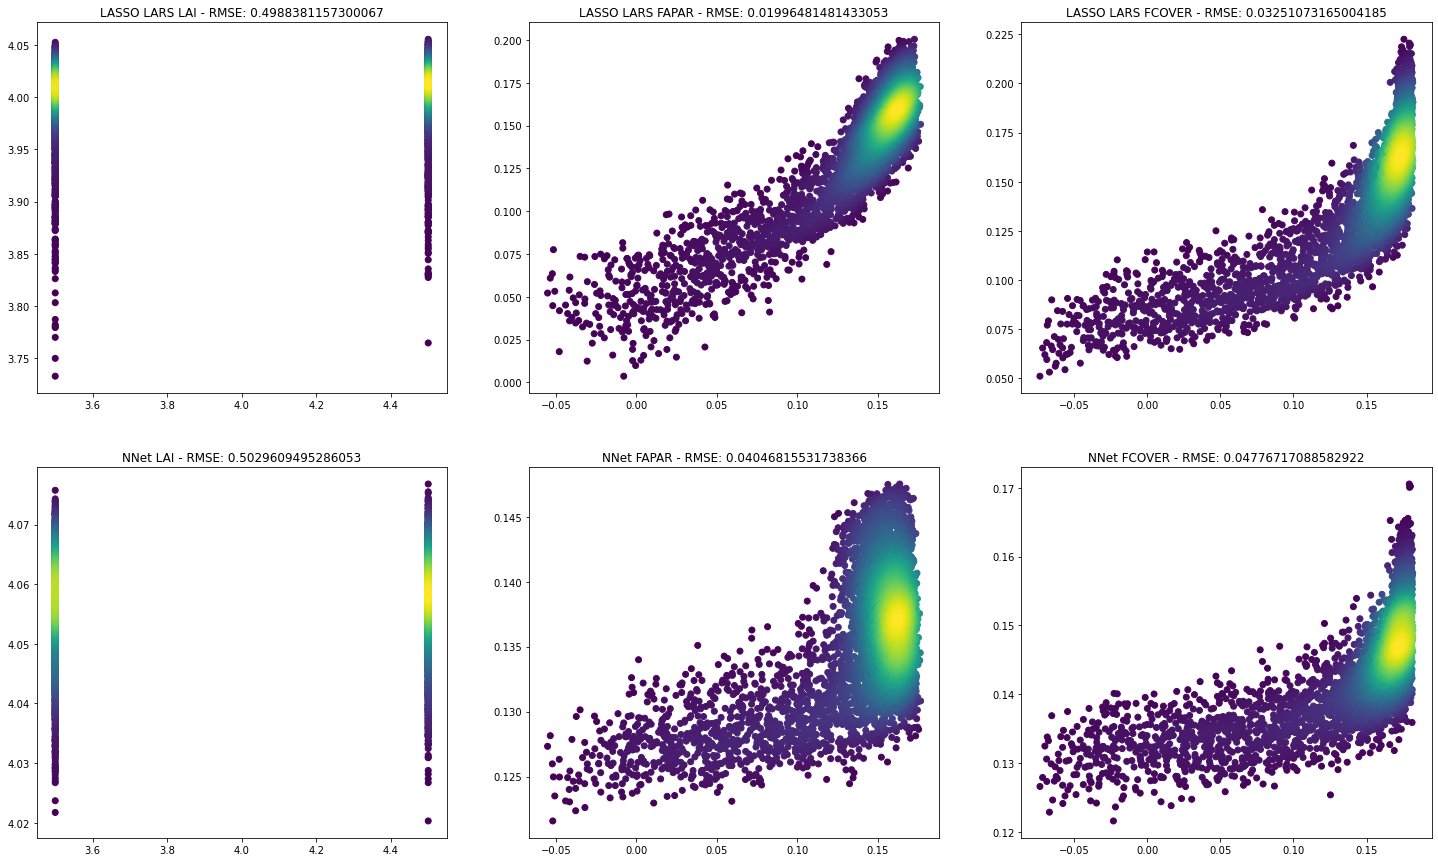

In [48]:
fig, ax = plt.subplots(2, 3, figsize=(25,15))

ax[0,0].scatter(x_skl_LAI, y_skl_LAI, c=z_skl_LAI)
ax[0,0].set_title('LASSO LARS LAI - RMSE: {}'.format(rmse_skl_LAI))

ax[1,0].scatter(x_tf_LAI, y_tf_LAI, c=z_tf_LAI)
ax[1,0].set_title('NNet LAI - RMSE: {}'.format(rmse_tf_LAI))

ax[0,1].scatter(x_skl_FAPAR, y_skl_FAPAR, c=z_skl_FAPAR)
ax[0,1].set_title('LASSO LARS FAPAR - RMSE: {}'.format(rmse_skl_FAPAR))

ax[1,1].scatter(x_tf_FAPAR, y_tf_FAPAR, c=z_tf_FAPAR)
ax[1,1].set_title('NNet FAPAR - RMSE: {}'.format(rmse_tf_FAPAR))

ax[0,2].scatter(x_skl_FCOVER, y_skl_FCOVER, c=z_skl_FCOVER)
ax[0,2].set_title('LASSO LARS FCOVER - RMSE: {}'.format(rmse_skl_FCOVER))

ax[1,2].scatter(x_tf_FCOVER, y_tf_FCOVER, c=z_tf_FCOVER)
ax[1,2].set_title('NNet FCOVER - RMSE: {}'.format(rmse_tf_FCOVER))

#plt.savefig("./matplotlib_outputs/uniform_replicates_w_weights_50000_samples_all_features.jpg")

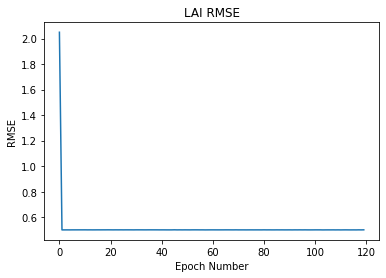

In [49]:
LAI_rmse = plt.plot(numpy.sqrt(LAI_history.history['mse']))
plt.xlabel("Epoch Number")
plt.ylabel("RMSE")
plt.title("LAI RMSE")
plt.show()

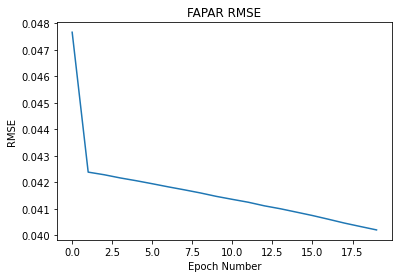

In [50]:
FAPAR_rmse = plt.plot(numpy.sqrt(FAPAR_history.history['mse']))
plt.xlabel("Epoch Number")
plt.ylabel("RMSE")
plt.title("FAPAR RMSE")
plt.show()

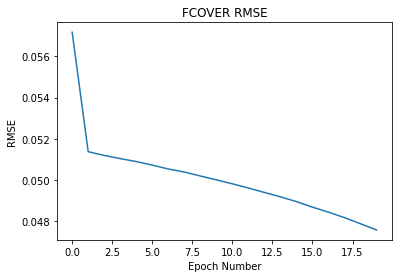

In [51]:
FCOVER_rmse = plt.plot(numpy.sqrt(FCOVER_history.history['mse']))
plt.xlabel("Epoch Number")
plt.ylabel("RMSE")
plt.title("FCOVER RMSE")
plt.show()